In [1]:
from google.colab import files
uploaded = files.upload()

Saving loss.py to loss.py
Saving model.py to model.py
Saving test.csv to test.csv
Saving TestDataset.py to TestDataset.py
Saving train.csv to train.csv
Saving TrainDataset.py to TrainDataset.py


In [4]:
!pip install livelossplot

In [0]:
import torch
import torchvision
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from livelossplot import PlotLosses
from loss import MSEloss_with_Mask
from model import AutoEncoder
from TestDataset import TestDataset
from TrainDataset import TrainDataset

In [0]:
transformations = transforms.Compose([transforms.ToTensor()])
train_dat = TrainDataset('train.csv', transformations)

In [292]:
print("Training Length: ", train_dat.__len__())
print("6th User Ratings: ", train_dat.__getitem__(7))

Training Length:  595
6th User Ratings:  tensor([0., 4., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


In [0]:
test_dat = TestDataset('test.csv', transformations)

In [296]:
print("Testing Length: ", test_dat.__len__())
print("6th User Ratings: ", test_dat.__getitem__(4))

Testing Length:  595
6th User Ratings:  tensor([4., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


## Dataloader

In [0]:
train_dl = DataLoader(dataset=train_dat, batch_size = 128, shuffle=True, num_workers = 1)

In [0]:
test_dl = DataLoader(dataset=test_dat, batch_size=128, shuffle=True, num_workers=1)

In [273]:
# Checking for availability of GPU

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## Training the Model

### Model

In [0]:
layer_sizes = [9559, 512, 512, 1024]

In [0]:
model = AutoEncoder(layer_sizes=layer_sizes, nl_type='selu', is_constrained=True, dp_drop_prob=0.0, last_layer_activations=False)

In [0]:
model = model.cuda()

### Loss and Optimizer

In [0]:
# Loss Function

criterion = MSEloss_with_Mask()
criterion = criterion.cuda()

In [0]:
# Optimizer

# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay= 1e-6, momentum = 0.9, nesterov = True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Fitting the Model

In [0]:
# hl1_tr_loss = []
# hl2_val_loss = []

In [0]:
# hl1_tr_loss = []
# hl2_val_loss = []

In [0]:
def train(model, criterion, optimizer, train_dl, test_dl, num_epochs=40):
  # We will run for 40 epochs
  liveloss = PlotLosses()
  for epoch in range(num_epochs):
    train_loss, valid_loss = [], []
    logs = {}
    prefix = ''

    # Training Part
    model.train()
    for i, data in enumerate(train_dl, 0):
      # Get the inputs
      inputs = labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()

      inputs = inputs.float()
      labels = labels.float()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      outputs = outputs.cuda()
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      ## -> Iterative Dense Output Re-feeding <- ##
      
      # Add a "for" loop to iterate as much you want
      
      # Zero the gradiants
      optimizer.zero_grad()
      
      # Important -> detach() the output, to avoid unecessary construction of 
      # the computational graph
      outputs = model(outputs.detach())
      outputs = outputs.cuda()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      logs[prefix + 'MMSE loss'] = loss.item()

    for i, data in enumerate(test_dl, 0):
      model.eval()
      inputs = labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()

      inputs = inputs.float()
      labels = labels.float()

      outputs = model(inputs)
      outputs = outputs.cuda()
      loss = criterion(outputs, labels)

      valid_loss.append(loss.item())
      prefix = 'val_'
      logs[prefix + 'MMSE loss'] = loss.item()

    lr2_tr_loss.append(np.mean(train_loss))
    lr2_val_loss.append(np.mean(valid_loss))
    liveloss.update(logs)
    liveloss.draw()
    print ("Epoch:", epoch+1, " Training Loss: ", np.mean(train_loss), " Valid Loss: ", np.mean(valid_loss))
    if epoch == num_epochs -1:
      return outputs

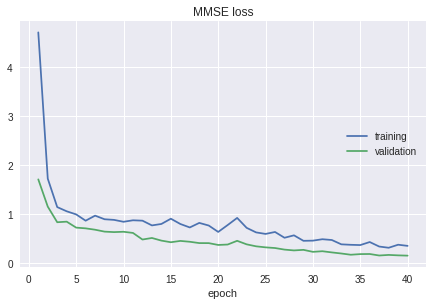

MMSE loss:
training   (min:    0.310, max:    4.696, cur:    0.348)
validation (min:    0.149, max:    1.702, cur:    0.149)
Epoch: 40  Training Loss:  0.355342960357666  Valid Loss:  0.15297851860523223


In [282]:
out = train(model, criterion, optimizer, train_dl, test_dl, 40)

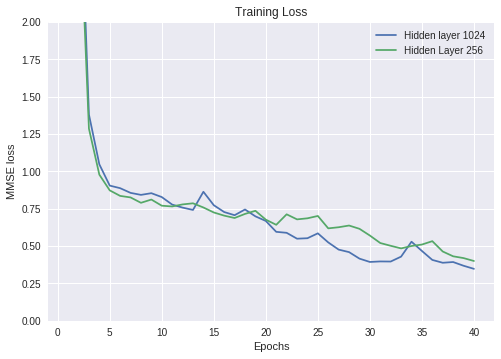

In [264]:
ep = np.arange(1,41)
plt.plot(ep, hl1_tr_loss)
plt.plot(ep, hl2_tr_loss)
plt.ylim(bottom=0, top=2)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MMSE loss")
plt.legend(["Hidden layer 1024", "Hidden Layer 256"])

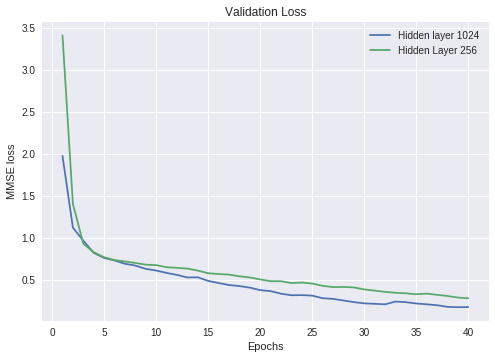

In [265]:
ep = np.arange(1,41)
plt.plot(ep, hl1_val_loss)
plt.plot(ep, hl2_val_loss)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MMSE loss")
plt.legend(["Hidden layer 1024", "Hidden Layer 256"])

In [299]:
# Input Batch

next(iter(train_dl))

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.5000, 3.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)

In [144]:
# Output of a batch after training
out

tensor([[2.6717, 0.8065, 0.5438,  ..., 1.9969, 2.6463, 0.9386],
        [3.2351, 3.0017, 2.7164,  ..., 0.3129, 0.6977, 0.8530],
        [3.2825, 2.9849, 2.8165,  ..., 2.4957, 3.5273, 1.3070],
        ...,
        [4.1001, 3.3715, 2.9336,  ..., 1.4340, 1.3578, 1.9669],
        [3.4013, 3.0175, 3.4592,  ..., 1.3811, 3.0438, 1.5754],
        [3.9306, 4.1596, 3.6475,  ..., 0.2179, 1.2647, 0.7416]],
       device='cuda:0', grad_fn=<AddmmBackward>)

So, we can conclude that the **output is Dense**, whereas the **input given to the model is sparse**. Thus we have succeeded in developing state-of-the-art technique in order to predict user ratings.